In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import matplotlib.patches as patches

from grid_criticality import analysis_path

import plot_utils as pu

In [2]:
data=pd.read_csv(f'{analysis_path}/criticality_data.csv', index_col=0).rename(columns={'delta_p': 'delta_p_mean'})

In [3]:
demo_lb = 50
demo_step = 10

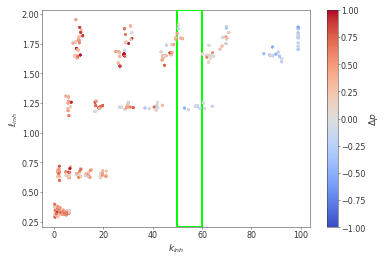

In [4]:
def plot_deltap_rk(ax):
    m = ax.scatter(data['k_inh_init'], data['r_inh_mean_init'], c=data['delta_p_mean'], cmap='coolwarm', s=5, vmin=-1, vmax=1, zorder=4)
    ax.set_xlabel('$k_{inh}$')
    ax.set_ylabel('$\ell_{inh}$')
    plt.colorbar(m, ax=ax, label='$\Delta p$')

    y0, y1 = ax.get_ylim()
    rect = patches.Rectangle((demo_lb, y0), demo_step, y1-y0, fc='none', ec='lime', lw=2, zorder=3)
    ax.add_artist(rect)

fig, ax = plt.subplots()
plot_deltap_rk(ax)

Text(0.5, 0, '$\\ell_{inh}$')

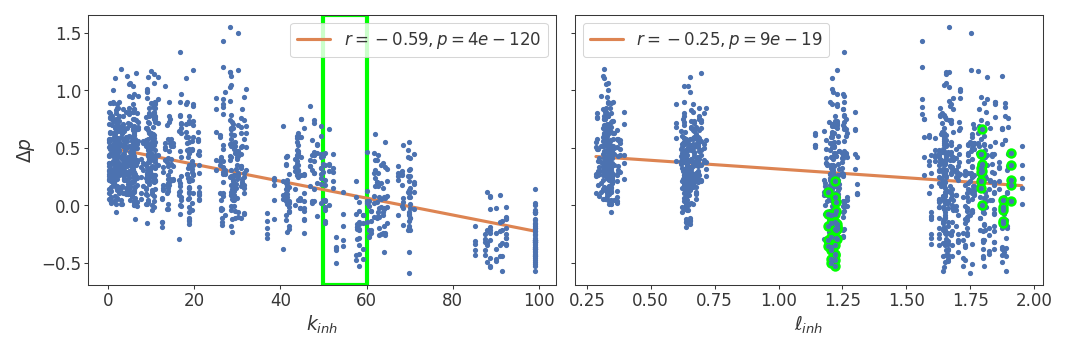

In [5]:
def scatter_deltap(ax_k, ax_r):
    for ax, k in ((ax_k, data['k_inh_init']), (ax_r, data['r_inh_mean_init'])):
        reg = stats.linregress(k, data['delta_p_mean'])
        extremes = np.asarray([min(k), max(k)])
        ax.plot(extremes, extremes*reg.slope + reg.intercept, 'C1', lw=1.5, label=f'$r={reg.rvalue:.2g}, p={reg.pvalue:.1g}$')
        ax.plot(k, data['delta_p_mean'], '.', ms=3)
        ax.legend()

    masked = data[(data['k_inh_init']>demo_lb) & (data['k_inh_init']<=demo_lb+demo_step)]
    ax_r.plot(masked['r_inh_mean_init'], masked['delta_p_mean'], '.', ms=8, color='lime')
    ax_r.plot(masked['r_inh_mean_init'], masked['delta_p_mean'], '.', ms=3, color='C0')

    y0, y1 = ax_k.get_ylim()
    rect = patches.Rectangle((demo_lb, y0), demo_step, y1-y0, fc='none', ec='lime', lw=2, zorder=0)
    ax_k.add_artist(rect)

fig, axs = plt.subplots(1,2, figsize=pu.fullwidth(2), dpi=150, sharey=True, layout='compressed')
scatter_deltap(*axs)
axs[0].set_ylabel('$\Delta p$')
axs[0].set_xlabel('$k_{inh}$')
axs[1].set_xlabel('$\ell_{inh}$')

In [6]:
def get_kslices(data, step=10):
    slices = []
    for lo in range(0, 95, int(step/2)):
        masked = data[(data['k_inh_init'] > lo) * (data['k_inh_init'] <= lo + step)].copy().reset_index(drop=True)
        masked['k_slice'] = lo
        masked['k_slice_size'] = step
        slices.append(masked)
    return slices

In [8]:
def correlate_slices(slices, xvar, yvar, xlabel=None, ylabel=None, axs=None, info='title'):
    slopes = []
    if axs is None:
        axs = [None]*len(slices)
    if xlabel is None:
        xlabel = str(xvar)
    if ylabel is None:
        ylabel = str(yvar)
    for ax, slice in zip(axs, slices):
        if len(slice) == 0:
            continue
        x = (slice[xvar] if type(xvar) is str else xvar(slice)).to_numpy()
        y = (slice[yvar] if type(yvar) is str else yvar(slice)).to_numpy()
        k, step = slice.loc[0, 'k_slice':'k_slice_size'].astype(int)

        reg = stats.linregress(x, y)
        slopes.append({'k_slice': k, 'k_slice_size': step, 'slope': reg.slope, 'pval': reg.pvalue})
        
        if ax is not None:
            xtremes = np.asarray([x.min(), x.max()])
            title = f'{k} < $k_{{inh}}$ <= {k+step}'
            infostr = f'$r={reg.rvalue:.2g}, p={reg.pvalue:.1g}$'
            ax.plot(xtremes, xtremes*reg.slope + reg.intercept,
                    label=infostr if info=='legend' else None,
                    lw=2 if reg.pvalue<.05 else 1, c='C1', zorder=5)

            ax.plot(x, y, '.', ms=3, zorder=6)

            if info == 'legend':
                ax.legend()
            elif info == 'title':
                title = f'{title}\n{infostr}'
            ax.set_title(title)
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)

    df = pd.DataFrame(slopes)
    df['significant'] = df['pval']<0.05/len(slices)
    df['positive'] = df['slope'] >= 0
    return df

In [9]:
slices = get_kslices(data)
slopes_dp = correlate_slices(slices, xvar='r_inh_mean_init', yvar='delta_p_mean')
slopes_k = correlate_slices(slices, xvar='r_inh_mean_init', yvar='k_inh_init')

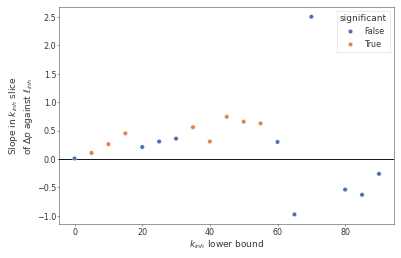

In [10]:
def plot_correlations(ax, slopes, y='$\Delta p$'):
    ax.axhline(0, color='k', lw=1, zorder=1)
    sns.scatterplot(ax=ax, data=slopes, x='k_slice', y='slope', zorder=2, hue='significant', size='significant', sizes=(20,20))
    ax.set_xlabel('$k_{inh}$ lower bound')
    ax.set_ylabel(f'Slope in $k_{{inh}}$ slice\nof {y} against $\ell_{{inh}}$')

fig, ax = plt.subplots()
plot_correlations(ax, slopes_dp)

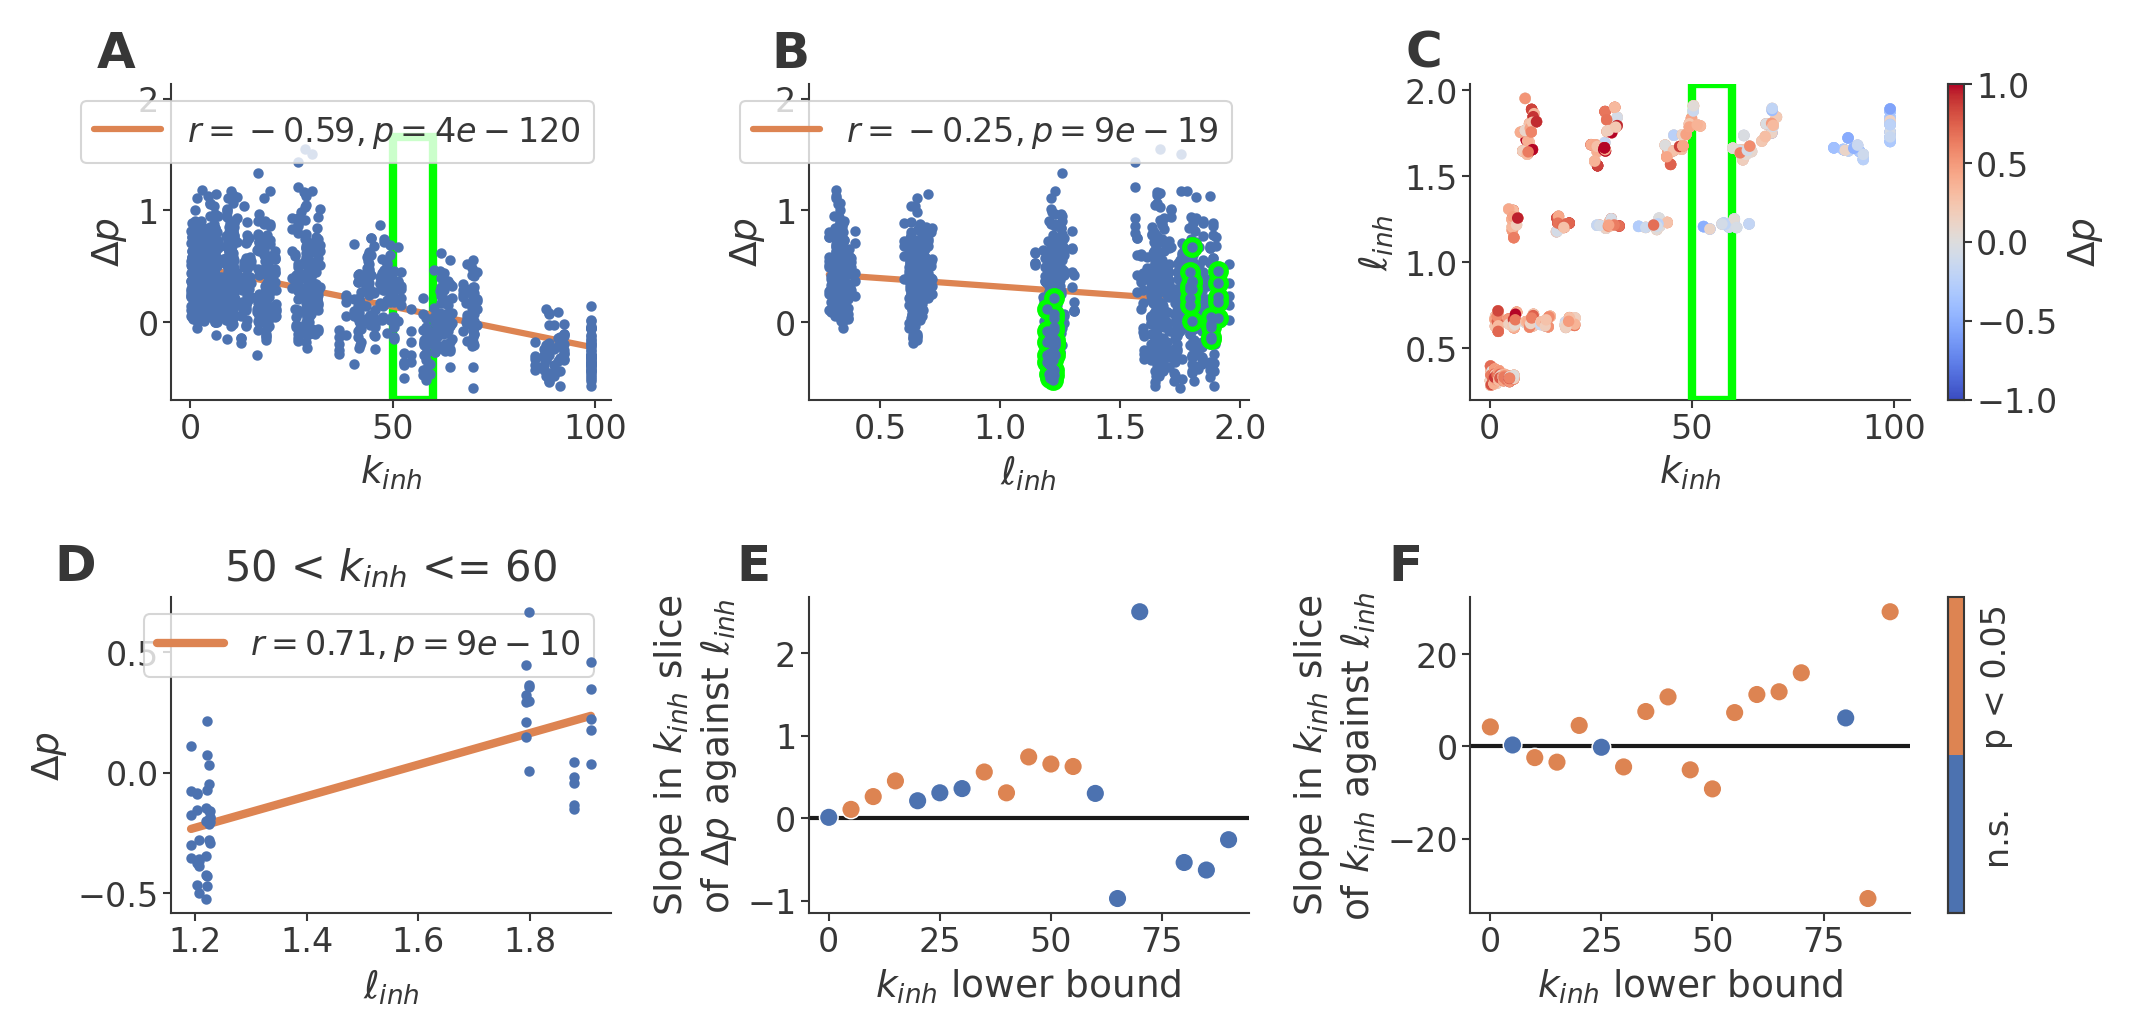

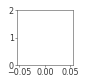

In [11]:
fig, axs = plt.subplots(2,3, layout='compressed', figsize=pu.fullwidth(3), dpi=300, gridspec_kw=dict(hspace=.1), facecolor='w')

scatter_deltap(*axs[0, :2])
axs[0, 0].set_ylabel('$\Delta p$')
axs[0, 1].set_ylabel('$\Delta p$')
axs[0, 0].set_xlabel('$k_{inh}$')
axs[0, 1].set_xlabel('$\ell_{inh}$')
for ax in axs[0, :2]:
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], ylim[1] + (ylim[1]-ylim[0])*.2)
pu.label_panel(axs[0,0], 0)
pu.label_panel(axs[0,1], 1, left=.5)

plot_deltap_rk(axs[0,2])
pu.label_panel(axs[0,2], 2, left=0.5)

correlate_slices(slices[10:11], xvar='r_inh_mean_init', yvar='delta_p_mean', xlabel='$\ell_{inh}$', ylabel='$\Delta p$', axs=axs[1, :1], info='legend')
pu.label_panel(axs[1,0], 3, left=.9)

plot_correlations(axs[1,1], slopes_dp)
pu.label_panel(axs[1,1], 4, left=0.5)
axs[1,1].legend().set_visible(False)

plot_correlations(axs[1,2], slopes_k, '$k_{inh}$')
pu.label_panel(axs[1,2], 5, left=0.5)
axs[1,2].legend().set_visible(False)

from matplotlib.colors import ListedColormap
nfig = plt.figure(figsize=(1,1))
m = plt.pcolormesh([[],[]], cmap=ListedColormap(['C0', 'C1']))
cb = fig.colorbar(m, ax=axs[1,2])
cb.set_ticks([.25, .75], labels=['n.s.', 'p < 0.05'], rotation='vertical', va='center')
cb.ax.tick_params(length=0, pad=4)

sns.despine(fig=fig)

fig.savefig('Figure 6.tif', bbox_inches='tight')

# Supplement

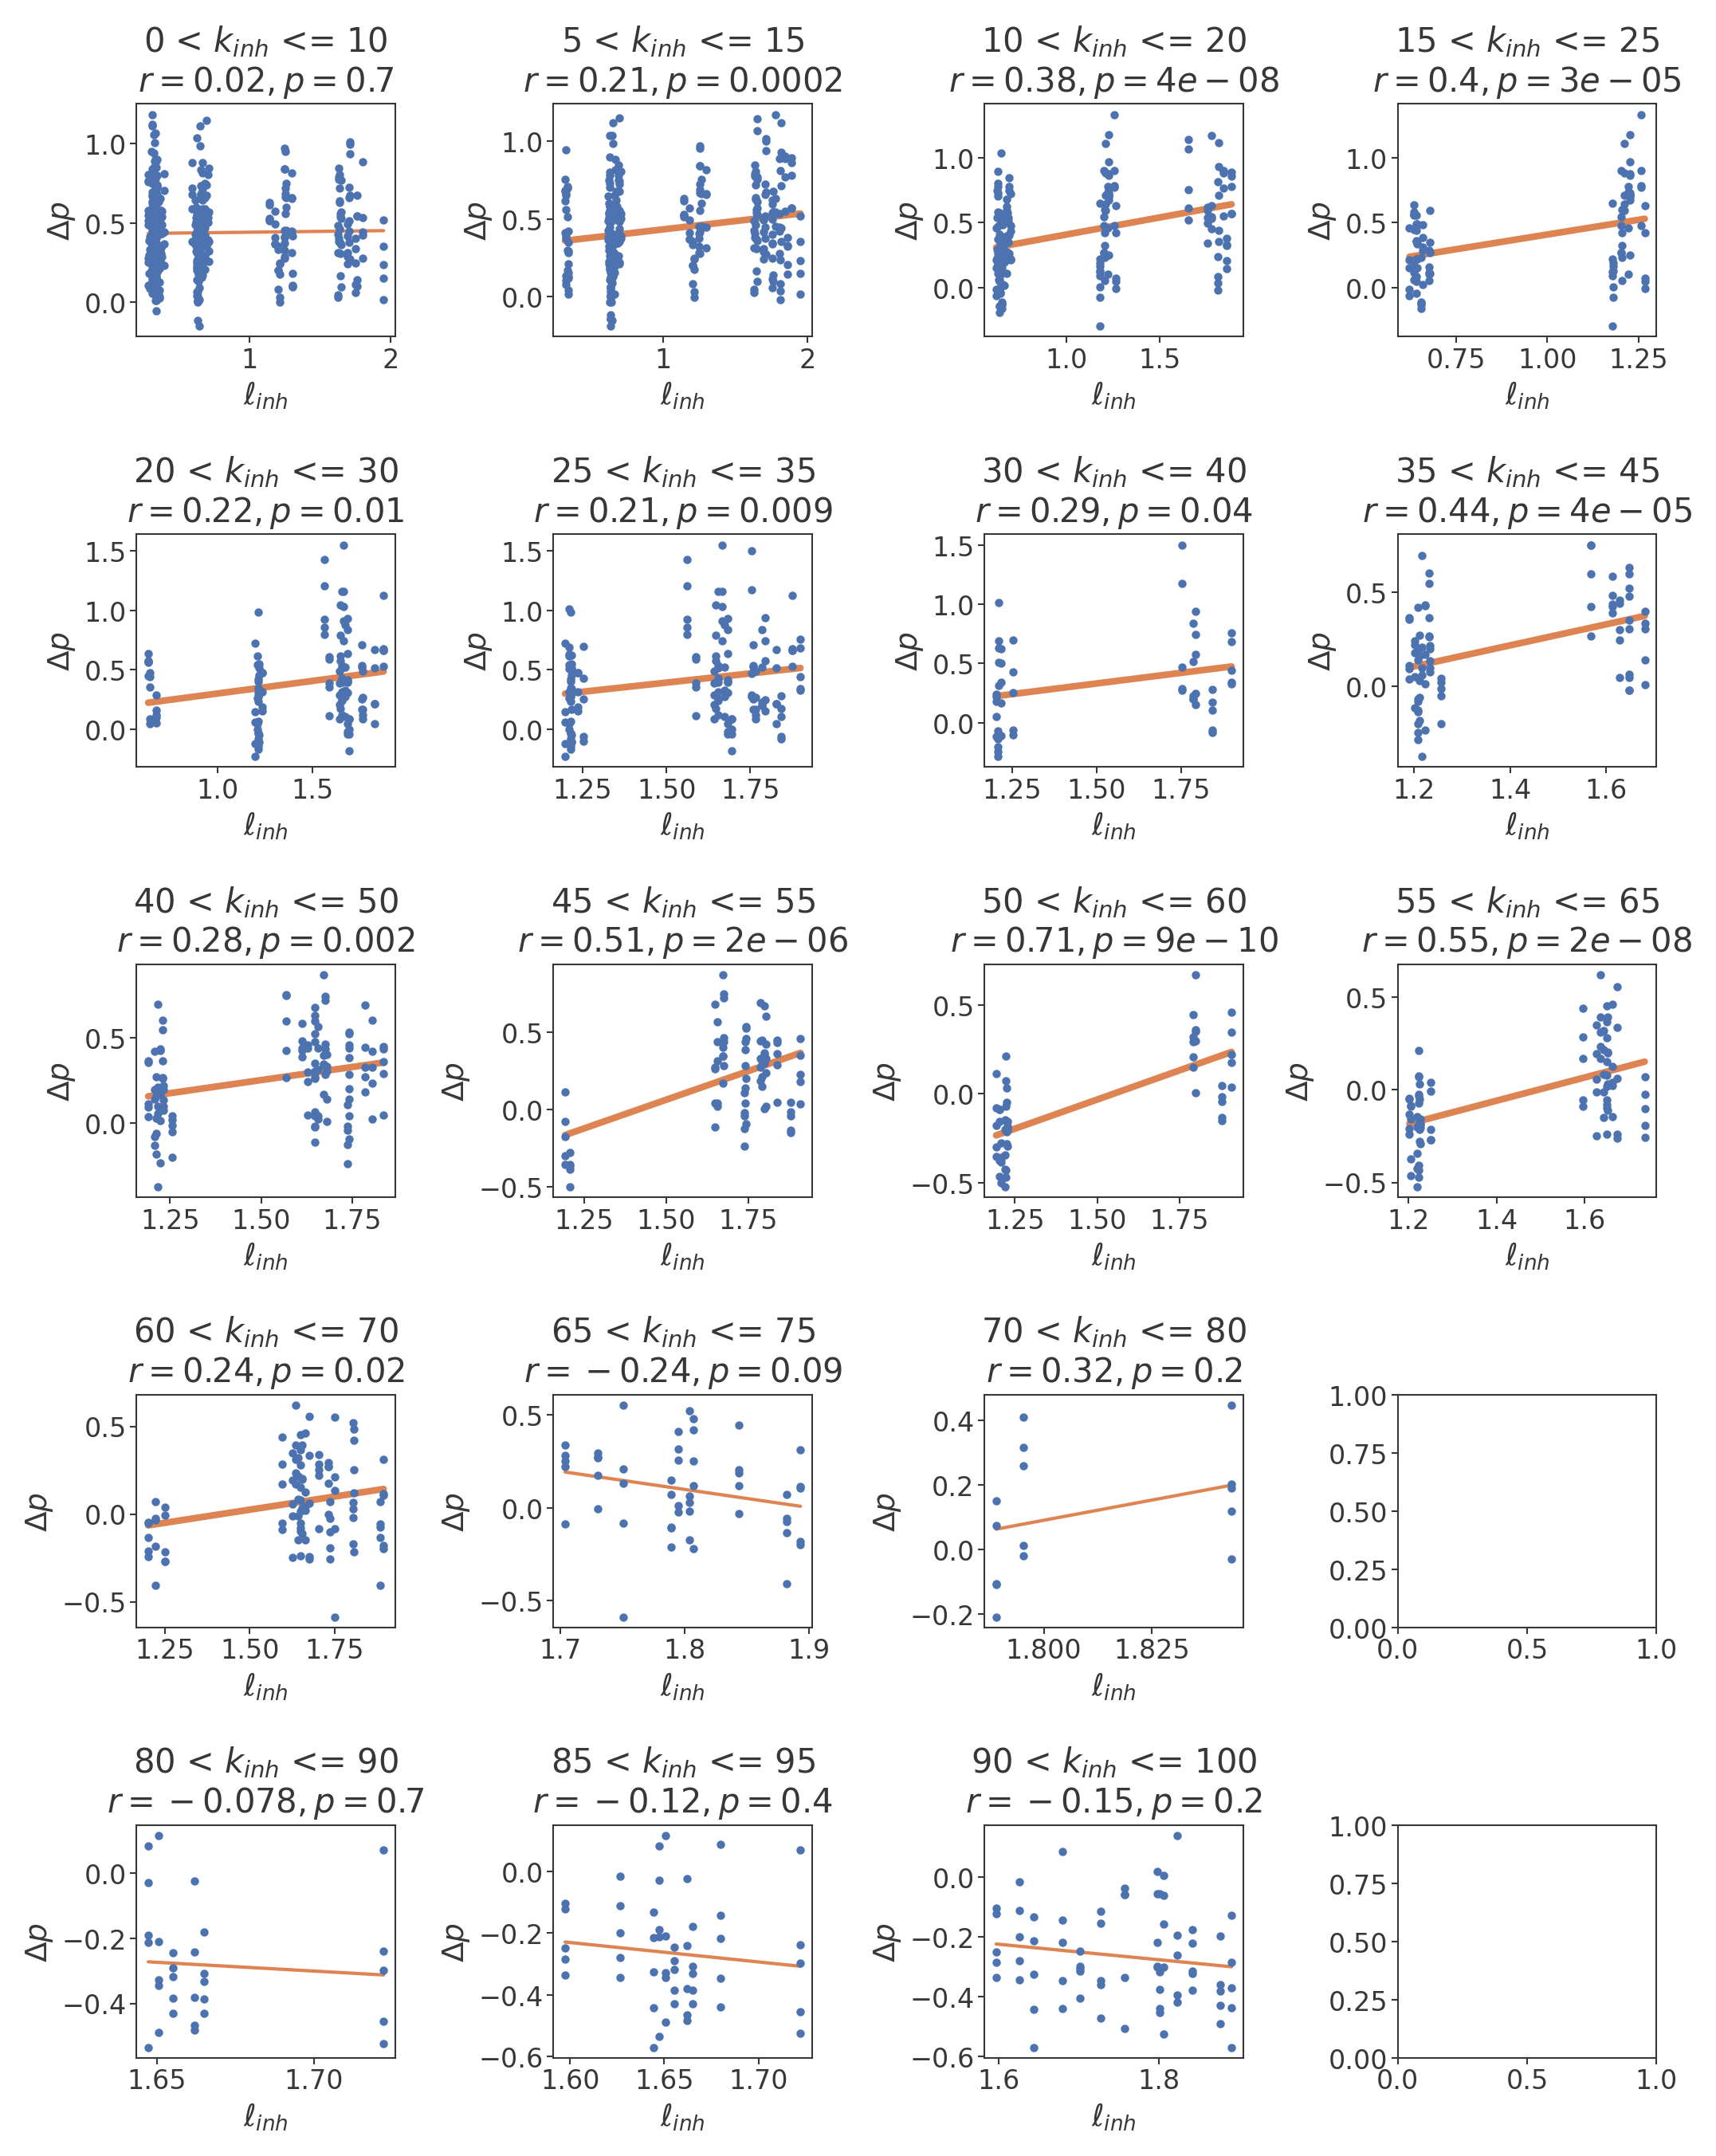

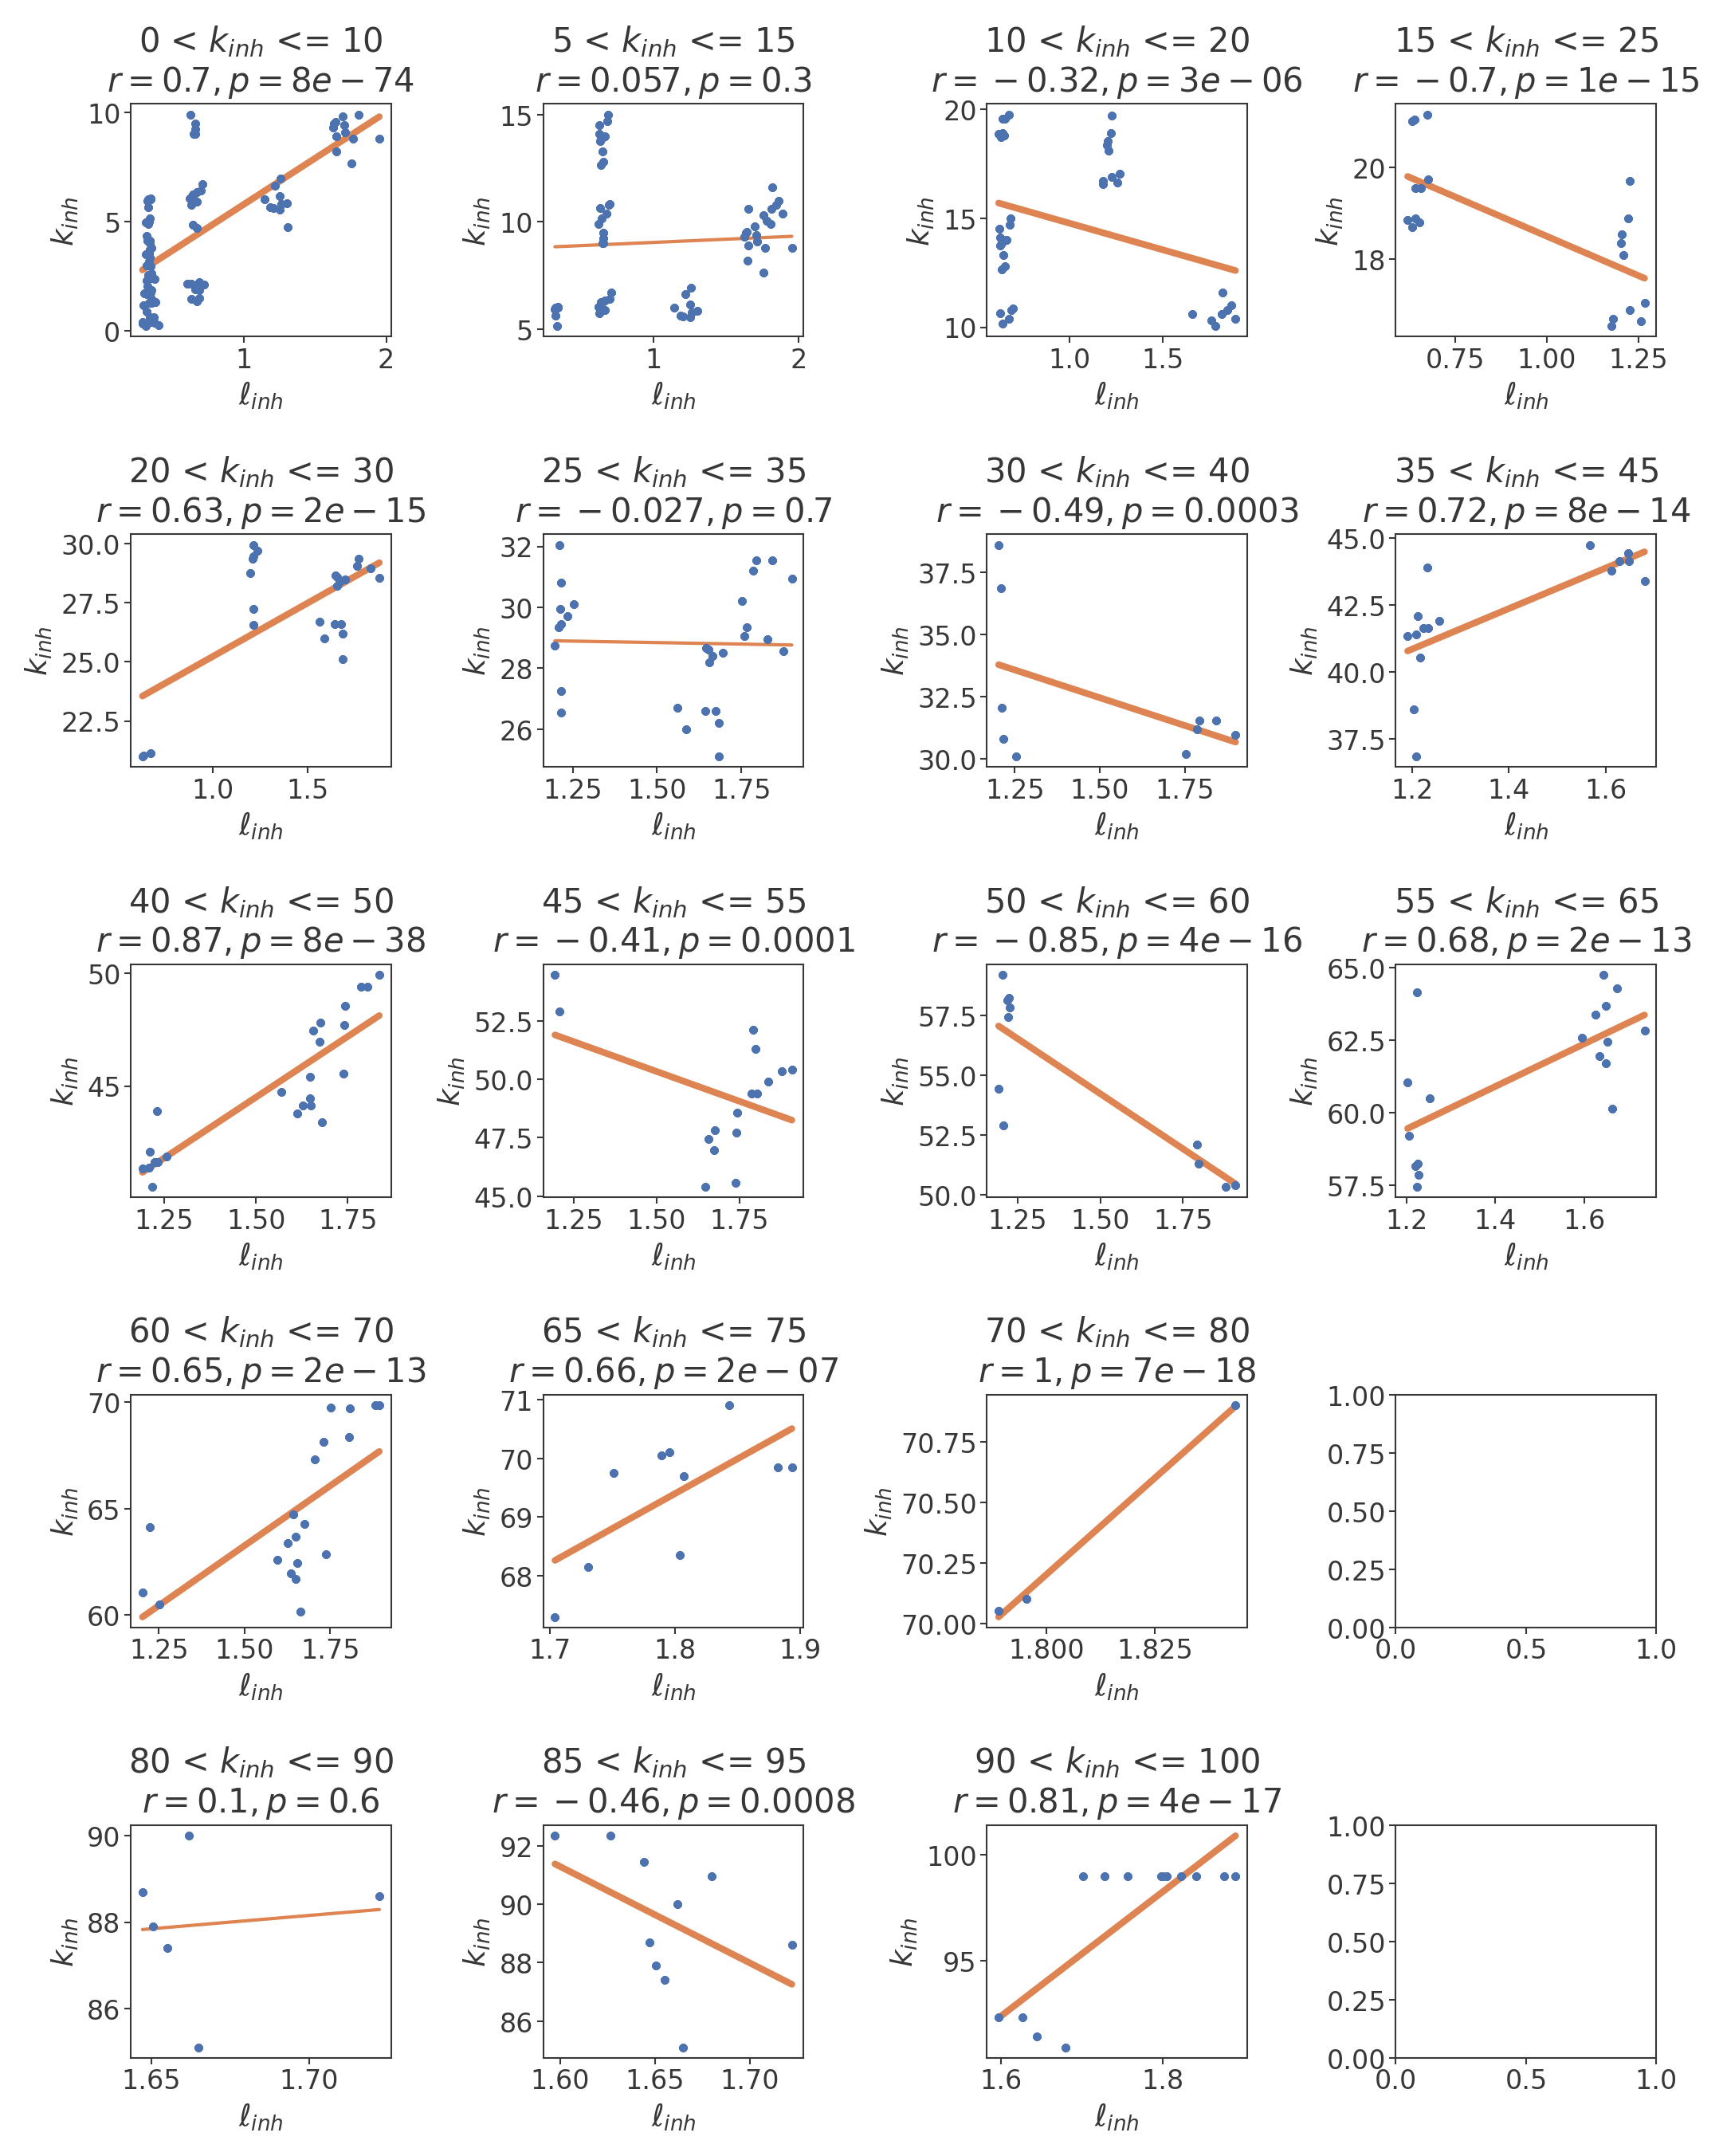

In [13]:
fig, axs = plt.subplots(5, 4, figsize=pu.fullwidth(8), layout='compressed', facecolor='w', dpi=300, gridspec_kw=dict(hspace=.1, wspace=.1))
slopes_dp = correlate_slices(slices, xvar='r_inh_mean_init', yvar='delta_p_mean', xlabel='$\ell_{inh}$', ylabel='$\Delta p$', axs=axs.flatten())
fig.savefig('Figure 6.Suppl1.tif', bbox_inches='tight')

fig, axs = plt.subplots(5, 4, figsize=pu.fullwidth(8), layout='compressed', facecolor='w', dpi=300, gridspec_kw=dict(hspace=.1, wspace=.1))
slopes_dp = correlate_slices(slices, xvar='r_inh_mean_init', yvar='k_inh_init', xlabel='$\ell_{inh}$', ylabel='$k_{inh}$', axs=axs.flatten())
fig.savefig('Figure 6.Suppl2.tif', bbox_inches='tight')